In [1]:
import time
import os
import sys
import pickle
import math

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

from nltk.tokenize import word_tokenize
from gensim.models.word2vec import Word2Vec

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix , precision_score , f1_score

from skopt.space import Real, Categorical, Integer
from skopt import forest_minimize, gbrt_minimize, gp_minimize
from skopt.callbacks import DeltaYStopper
from skopt.utils import use_named_args

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
import torchvision

import xgboost as xgb

%matplotlib inline

c:\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import linecache
import pprint

def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print ('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(filename, lineno, line.strip(), exc_obj))
    return

In [3]:
def my_classification_report(y_actual , y_predicted):
    print(classification_report(y_actual, y_pred))
    acc = accuracy_score(y_actual , y_predicted)
    print('accuracy : {}'.format(acc))
   
    conf_mat=confusion_matrix(y_actual, y_pred)
    #print(conf_mat)
    #plt.figure(figsize=(20,20))
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(le.classes_)
    ax.yaxis.set_ticklabels(le.classes_)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    #plt.savefig('conf_matrix.png')
    plt.show()

In [4]:
data = pd.read_csv('./sentiment_analysis.csv'
                   , low_memory = False
                   )
data.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [5]:
data.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [6]:
data.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

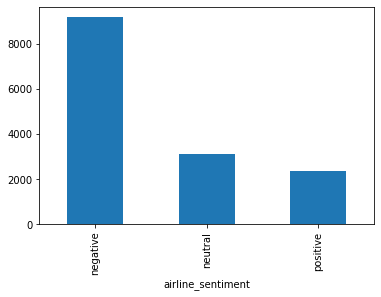

In [7]:
data.groupby('airline_sentiment')['text'].count().plot('bar')

In [8]:
data = data[['airline_sentiment','text']]
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [9]:
#TEXT CLEANING

#Remove words starting with @ as they aree just references
data['cleaned_text'] = data['text'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('@')))

#Remove .
data['cleaned_text'] = data['cleaned_text'].str.lower().replace('.','')

#Remove Special Characters
data['cleaned_text'] = data['cleaned_text'].str.replace('[^\w\s]','')

In [10]:
data['seq_length'] = data['cleaned_text'].apply(lambda x: len(str(x).split(" ")))
data.seq_length.describe()

count    14640.000000
mean        16.685587
std          6.948965
min          1.000000
25%         11.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: seq_length, dtype: float64

In [11]:
le = LabelEncoder()
data['airline_sentiment_encoded'] = le.fit_transform( data['airline_sentiment'])
data.head()

,airline_sentiment,text,cleaned_text,seq_length,airline_sentiment_encoded
0,neutral,@VirginAmerica What @dhepburn said.,what said,2,1
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...,8,2
2,neutral,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...,11,1
3,negative,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,16,0
4,negative,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,9,0


In [12]:
data.shape

(14640, 5)

In [13]:
st_time = time.time()
sentence_corpus = []
for i in data.cleaned_text:
    sentence_corpus.append(i.split())
len(sentence_corpus)
print('time taken to process : {} seconds'.format(round(time.time() - st_time ,2)))

time taken to process : 0.04 seconds


In [14]:
st_time = time.time()
vocab = []
for i in data.cleaned_text:
    for j in i.split():
        if j not in vocab:
            vocab.append(j)
vocab_size = len(vocab)
print('vocab_size : {}'.format(vocab_size))
print('time taken to process : {} seconds'.format(round(time.time() - st_time ,2)))

vocab_size : 15884
time taken to process : 4.16 seconds


In [15]:
word_to_idx = {}
idx_to_word = {}
for i in enumerate(vocab):
    #print(i)
    word_to_idx[i[1]] = i[0]
    idx_to_word[i[0]] = i[1]
print(len(word_to_idx))
print(len(idx_to_word))
print('time taken to map vocab : {} seconds'.format(round(time.time() - st_time ,2)))

15884
15884
time taken to map vocab : 4.18 seconds


In [16]:
max_sentence_length = 35
seq_len = max_sentence_length
print('max_sentence_length : {}'.format(max_sentence_length))
for i in range(0,len(sentence_corpus)):
    sentence = sentence_corpus[i]
    if len(sentence) < max_sentence_length :
        padding_length = max_sentence_length - len(sentence)
        #print(padding_length)
        for j in range(len(sentence) , max_sentence_length) :
            sentence.append('<>')

max_sentence_length : 35


In [17]:
vec_size = 256
st_time = time.time()
word2vec = Word2Vec(sentence_corpus, window=3 , min_count=1, size=vec_size , workers=os.cpu_count())
print('time taken to train word2vec : {} seconds'.format(round(time.time() - st_time ,2)))

time taken to train word2vec : 1.39 seconds


In [18]:
def vectorize_sentence(sentence):
    sentence = sentence.split()
    input_data = np.zeros((seq_len,vec_size))
    #print(corpus)
    k = 0
    for i in sentence:
        if k < seq_len : 
            if i == '<>':
                word_vector = np.zeros(vec_size)
            else:
                word_vector = word2vec.wv[i] 
            input_data[k] = word_vector
        else:
            continue
        k+=1
        #print(i)
    return input_data

In [19]:
X = []
print_every = 1000
ctr = 0
st_time = time.time()
total_records = data.shape[0]
for idx in data.index :
    text = data.loc[idx].cleaned_text
    feature = vectorize_sentence(text)
    X.append(feature)
    ctr+=1
    if ctr % print_every == 0 :
        print('records done : {}/{} \t time : {}'.format(ctr , total_records , round(time.time() - st_time ,2)))
        st_time = time.time()

records done : 1000/14640 	 time : 0.33
records done : 2000/14640 	 time : 0.32
records done : 3000/14640 	 time : 0.31
records done : 4000/14640 	 time : 0.33
records done : 5000/14640 	 time : 0.31
records done : 6000/14640 	 time : 0.3
records done : 7000/14640 	 time : 0.3
records done : 8000/14640 	 time : 0.3
records done : 9000/14640 	 time : 0.3
records done : 10000/14640 	 time : 0.32
records done : 11000/14640 	 time : 0.31
records done : 12000/14640 	 time : 0.33
records done : 13000/14640 	 time : 0.31
records done : 14000/14640 	 time : 0.31


In [20]:
Y = data['airline_sentiment_encoded'].values
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=7)

In [21]:
batch_size = 8
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
train_dataset = torch.utils.data.TensorDataset(x_train ,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)
val_dataset = torch.utils.data.TensorDataset(x_val ,y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [22]:
output_size = len(le.classes_)
batch_size = batch_size
drop_out_probability = 0.5
input_size = vec_size
hidden_size = input_size
num_layers = 1

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('CUDA available, training on GPU')
else :
    device = torch.device("cpu")
    print('cuda NOT available, training on CPU') 
    
#device = torch.device("cpu")

CUDA available, training on GPU


In [24]:
class NN_Classifier(nn.Module):
    def __init__(self , input_size , hidden_size , num_layers , output_size):
        super(NN_Classifier ,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        #lstm layer
        self.lstm1 = nn.LSTM(input_size = input_size
                             , hidden_size = hidden_size 
                             , num_layers = num_layers
                             , batch_first = True 
                             ,dropout=drop_out_probability
                             )
        
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(in_features = input_size , out_features = hidden_size)
        
        #Droput layer before output
        self.dropout1 = nn.Dropout(p = drop_out_probability)
        
        # Output layer, 10 units - one for each digit
        self.out = nn.Linear(in_features = hidden_size , out_features = output_size)
        
    def _init_hidden(self,batch_size):
        hidden = torch.zeros((self.num_layers, batch_size , self.hidden_size),dtype = torch.float64)
        c_0 = torch.zeros((self.num_layers, batch_size , self.hidden_size),dtype = torch.float64)
        return hidden.to(device) , c_0.to(device)
        
    def forward(self,x):
        
        #create initial hidden layer of zeros and intial state of zeros
        hidden , c_0 = self._init_hidden(batch_size)
        
        # Pass the input tensor through LSTM
        lstm_out ,hidden = self.lstm1(x,(hidden,c_0))
        
        #Transpose tensor before feeding into Linear layer
        lstm_out = lstm_out.transpose(dim0 = 0, dim1 = 1)
        x = self.fc1(lstm_out[-1])
        
        #Dropout layer
        x = self.dropout1(x)
        
        #Fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        
        #Output layer
        x = self.out(x)
        
        return x
    
model = NN_Classifier(input_size = input_size 
                        , hidden_size = hidden_size
                        , output_size = output_size
                        , num_layers = num_layers)
model.double()

c:\python\python37\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


NN_Classifier(
  (lstm1): LSTM(256, 256, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5)
  (out): Linear(in_features=256, out_features=3, bias=True)
)

In [25]:
epochs = 5
loss_fn = F.cross_entropy

learning_rate = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print_every = 200
model.to(device)


# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
patience_ctr = 0
patience = 2


st_time = time.time()
    
for epoch in range(1,epochs+1):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    batch = 0
    #loss = 0
    st_time = time.time()
    model.train()
    for x, y in train_dataloader :
        x = x.to(device)
        y = y.long().to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        
        #y_pred = y_pred.unsqueeze(0)
        loss = loss_fn(y_pred , y)

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (batch % print_every == 0):
            print('epoch: {}/{}\tbatch: {}/{}\ttrain loss : {}\ttime : {} secs '.format(epoch, 
                                                                                       epochs , 
                                                                                       batch,
                                                                                       len(train_dataloader) , 
                                                                                       loss.item() , 
                                                                                       round(time.time() - st_time , 2)))
            st_time = time.time()
            
        batch +=1

    #Calculate Validation loss
    val_acc = 0
    model = model.eval()
    for x_v, y_v in val_dataloader :
        x_v = x_v.to(device)
        y_v = y_v.long().to(device)
        
        y_pred = model(x_v)
        loss = loss_fn(y_pred , y_v)
        
        valid_losses.append(loss.item())
    
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    #Early stopping
    if valid_loss > train_loss:
        patience_ctr +=1
        print('patience_ctr : {}'.format(patience_ctr))
        if patience_ctr >= patience:
            print('early stoppping since valid_loss > train_loss')
            break
    else :
        patience_ctr = 0
    
    epoch_len = len(str(epochs))
    print('\nepoch : {}/{}\t train_loss :{}\t validation loss : {}'.format(epoch , 
                                                                           epochs, 
                                                                           train_loss , 
                                                                           valid_loss))
    
            
    print('epoch : {}/{} \t train loss : {} \t time required : {} secs\n'.format(epoch, 
                                                                          epochs, 
                                                                          train_loss,
                                                                          round(time.time() - st_time , 2)))


epoch: 1/5	batch: 0/1647	train loss : 1.0671220212429282	time : 1.91 secs 
epoch: 1/5	batch: 200/1647	train loss : 0.9199494177764738	time : 11.43 secs 
epoch: 1/5	batch: 400/1647	train loss : 0.5859219247085287	time : 11.35 secs 
epoch: 1/5	batch: 600/1647	train loss : 0.8071059211872351	time : 11.54 secs 
epoch: 1/5	batch: 800/1647	train loss : 1.0673975646845089	time : 11.39 secs 
epoch: 1/5	batch: 1000/1647	train loss : 1.0168548410312195	time : 11.51 secs 
epoch: 1/5	batch: 1200/1647	train loss : 1.0413212656527466	time : 11.53 secs 
epoch: 1/5	batch: 1400/1647	train loss : 0.5913696436532068	time : 11.38 secs 
epoch: 1/5	batch: 1600/1647	train loss : 1.2215264860117612	time : 11.36 secs 

epoch : 1/5	 train_loss :0.8405276141259248	 validation loss : 0.8122330777956154
epoch : 1/5 	 train loss : 0.8405276141259248 	 time required : 7.24 secs

epoch: 2/5	batch: 0/1647	train loss : 0.7947038666789403	time : 0.79 secs 
epoch: 2/5	batch: 200/1647	train loss : 0.9704418375710036	time 

In [26]:
st_time = time.time()
ctr = 0
print_every = 50
model = model.eval()
for x_v, y_v in val_dataloader :
    x_v = x_v.to(device)
    #y_v = y_v.to(device)
   
    op = model(x_v)
    op = torch.argmax(F.softmax(op , dim = 1), dim = 1)
    if ctr == 0:
        y_pred = op
        y_actual = y_v
    else:
        y_pred = torch.cat((y_pred , op))
        y_actual = torch.cat((y_actual , y_v))
   
    ctr += 1
   
    if ctr % print_every == 0:
        print(ctr)
print('time taken for prediction :{} seconds'.format(time.time() - st_time ))

50
100
150
time taken for prediction :4.579709053039551 seconds


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       916
           1       0.54      0.56      0.55       312
           2       0.64      0.44      0.52       236

    accuracy                           0.72      1464
   macro avg       0.66      0.62      0.63      1464
weighted avg       0.72      0.72      0.72      1464

accuracy : 0.7240437158469946


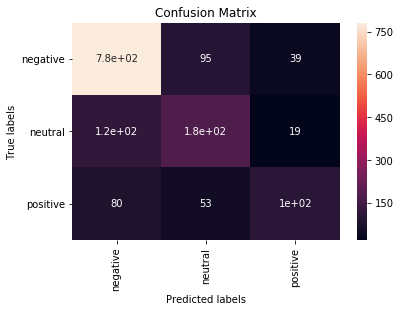

In [27]:
y_actual = y_val
y_pred = y_pred.cpu().detach().numpy()
my_classification_report(y_actual = y_actual , y_predicted = y_pred)